In [1]:
library(readr)
library(dplyr)
library(stringr)
library(lfe)
library(ggsci)
library(lubridate)
library(ggplot2)
library(doMC)
library(gridExtra)
library(ggpubr)
library(stargazer)
library(scales)
registerDoMC(4)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘lubridate’


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
fp <- '/pool001/mfzhao/'
df <- read_rds(str_c(fp, '/PROCESSED_DATA/panel_pre_xgr.RDS'))

In [3]:
df %>%
    mutate(as_newcases  = asinh(newcases),
           as_newdeaths = asinh(newdeaths),
           as_stnewcases  = asinh(stnewcases),
           as_stnewdeaths = asinh(stnewdeaths),
           ct_unemp_rate = as.numeric(ct_unemp_rate),
           st_unemp_rate = as.numeric(st_unemp_rate)) %>%
    select(key,
           date, 
           cluster,
           n,
           log_mcbgv,
           log_pnchd,
           log_pgt1hafh, 
           log_ppthlt75,
           log_pgt2kmt,
           matches('unemp'),
           matches('^log_stalter_'), 
           matches('^[pt][rm][ca][px][01][0-9]$'),
           matches('^p[123]...$'),
           matches('stalter_p[123]...$'),
           matches('stalter[NF]'),
           matches('stalter_[pt][rm][ca][px][01][0-9]$'),
           matches('as_(st)?new')) -> df

In [4]:
cns <- colnames(df)
cns

[1] "key"                  "date"                 "cluster"             
 [4] "n"                    "log_mcbgv"            "log_pnchd"           
 [7] "log_pgt1hafh"         "log_ppthlt75"         "log_pgt2kmt"         
[10] "ct_unemp_rate"        "st_unemp_rate"        "log_stalter_mcbgv"   
[13] "log_stalter_pnchd"    "log_stalter_pgt1hafh" "log_stalter_ppthlt75"
[16] "log_stalter_pgt2kmt"  "prcp01"               "prcp02"              
[19] "prcp03"               "prcp04"               "prcp05"              
[22] "prcp06"               "prcp07"               "prcp08"              
[25] "prcp09"               "prcp10"               "tmax02"              
[28] "tmax03"               "tmax04"               "tmax05"              
[31] "tmax06"               "tmax07"               "tmax08"              
[34] "tmax09"               "tmax10"               "p1sdp"               
[37] "p2shp"                "p3rop"                "stalter_p1sdp"       
[40] "stalter_p2shp"        "stalter_p3rop"        "stalterNear_p1sdp"   
[43] "stalterNear_p2shp"    "stalterNear_p3rop"    "stalterFar_p1sdp"    
[46] "stalterFar_p2shp"     "stalterFar_p3rop"     "stalter_prcp01"      
[49] "stalter_prcp02"       "stalter_prcp03"       "stalter_prcp04"      
[52] "stalter_prcp05"       "stalter_prcp06"       "stalter_prcp07"      
[55] "stalter_prcp08"       "stalter_prcp09"       "stalter_prcp10"      
[58] "stalter_tmax02"       "stalter_tmax03"       "stalter_tmax04"      
[61] "stalter_tmax05"       "stalter_tmax06"       "stalter_tmax07"      
[64] "stalter_tmax08"       "stalter_tmax09"       "stalter_tmax10"      
[67] "as_newcases"          "as_newdeaths"         "as_stnewcases"       
[70] "as_stnewdeaths"

In [5]:
ldvs <- c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd')
dvs  <- c('mcbgv', 'pnchd', 'pgt1hafh', 'pgt2kmt')

In [6]:
get_coefs <- function(dv, vars, ivmod = F, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | ')

    if(ivmod == T) {
        alter_weather <- str_c(cns[str_detect(cns, '^stalter_[pt][rm][ca][px][01][0-9]$')], collapse = ' + ')
        iv <- ifelse(str_detect(dv, 'log'), str_replace(dv, 'log', 'log_stalter'), str_c('alter_', dv))
        ivf <- str_c('(', iv, ' ~ ', alter_weather, ') | cluster')
        rhs <- str_c(rhs, ivf)
    } else {
        rhs <- str_c(rhs, '0 | cluster')
    }
    form  <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df, weights = df$n, ...)
    
    as.data.frame(summary(model)$coef) %>%
        mutate(var   = rownames(.),
               dv    = dv,
               model = ifelse(vars == f1, 'base', 
                              ifelse(vars == f2, 'ap', 'apnf')),
               model = ifelse(ivmod, str_c(model, ' + iv'), model)) %>%
        filter(!str_detect(var, '[pPtT][rRmM][cCaA][pPxX]')) %>%
        select(7, 6, 5, 1, 2, 3, 4) -> out
    
    colnames(out) <- c('model', 'dv', 'var', 'estimate', 'se', 't', 'p-val')
    return(out)
}

In [7]:
ctrls <- '+ prcp01 + prcp02 + prcp03 + prcp04 + prcp05 + prcp06 + prcp07 + prcp08 + prcp09 + prcp10 + 
            tmax02 + tmax03 + tmax04 + tmax05 + tmax06 + tmax07 + tmax08 + tmax09 + tmax10 + 
            as_newcases + as_newdeaths + as_stnewcases + as_stnewdeaths + ct_unemp_rate + st_unemp_rate '
f1    <- str_c(' p1sdp + p2shp + p3rop ', ctrls)  
f2    <- str_c(' p1sdp + p2shp + p3rop + stalter_p1sdp + stalter_p2shp + stalter_p3rop ', ctrls)
f3    <- str_c(' p1sdp + p2shp + p3rop + stalterNear_p1sdp + stalterNear_p2shp + stalterNear_p3rop +
                 stalterFar_p1sdp + stalterFar_p2shp + stalterFar_p3rop ', ctrls)

In [8]:
foreach(dv = ldvs, .combine = rbind) %:% 
    foreach(f = c(f1, f2, f3), .combine = rbind) %:%
    foreach(ivmod = c(T, F), .combine = rbind) %dopar%
    get_coefs(dv, f, ivmod) -> coefs

In [27]:
coefs %>%
    filter(var == 'p2shp') %>%
    filter(model == 'base') %>%
    filter(!str_detect(model, 'iv'), model != 'apnf') %>%
    summarize(min  = min(exp(estimate) - 1),
              max  = max(exp(estimate) - 1),
              mean = mean(exp(estimate) - 1))

coefs %>%
    filter(var == 'p3rop') %>%
        filter(model == 'base') %>%
    filter(!str_detect(model, 'iv'), model != 'apnf') %>%
    summarize(min = min(exp(estimate) - 1),
              max = max(exp(estimate) - 1),
               mean = mean(exp(estimate) - 1))

coefs %>%
    filter(var == 'stalter_p1sdp') %>%
    filter(!str_detect(model, 'iv'), model != 'apnf') %>%
    summarize(min  = min(exp(estimate) - 1),
              max  = max(exp(estimate) - 1),
              mean = mean(exp(estimate) - 1))

coefs %>%
    filter(var == 'stalter_p2shp') %>%
    filter(!str_detect(model, 'iv'), model != 'apnf') %>%
    summarize(min  = min(exp(estimate) - 1),
              max  = max(exp(estimate) - 1),
              mean = mean(exp(estimate) - 1))

coefs %>%
    filter(var == 'stalter_p3rop') %>%
    filter(!str_detect(model, 'iv'), model != 'apnf') %>%
    summarize(min = min(exp(estimate) - 1),
              max = max(exp(estimate) - 1),
               mean = mean(exp(estimate) - 1))

min,max,mean
<dbl>,<dbl>,<dbl>
-0.03512586,-0.0282385,-0.03031691


min,max,mean
<dbl>,<dbl>,<dbl>
0.01987253,0.02799747,0.02404431


min,max,mean
<dbl>,<dbl>,<dbl>
-0.08168051,-0.06129055,-0.07445315


min,max,mean
<dbl>,<dbl>,<dbl>
-0.1176446,-0.08270042,-0.1064879


min,max,mean
<dbl>,<dbl>,<dbl>
0.1210666,0.2138602,0.1700797


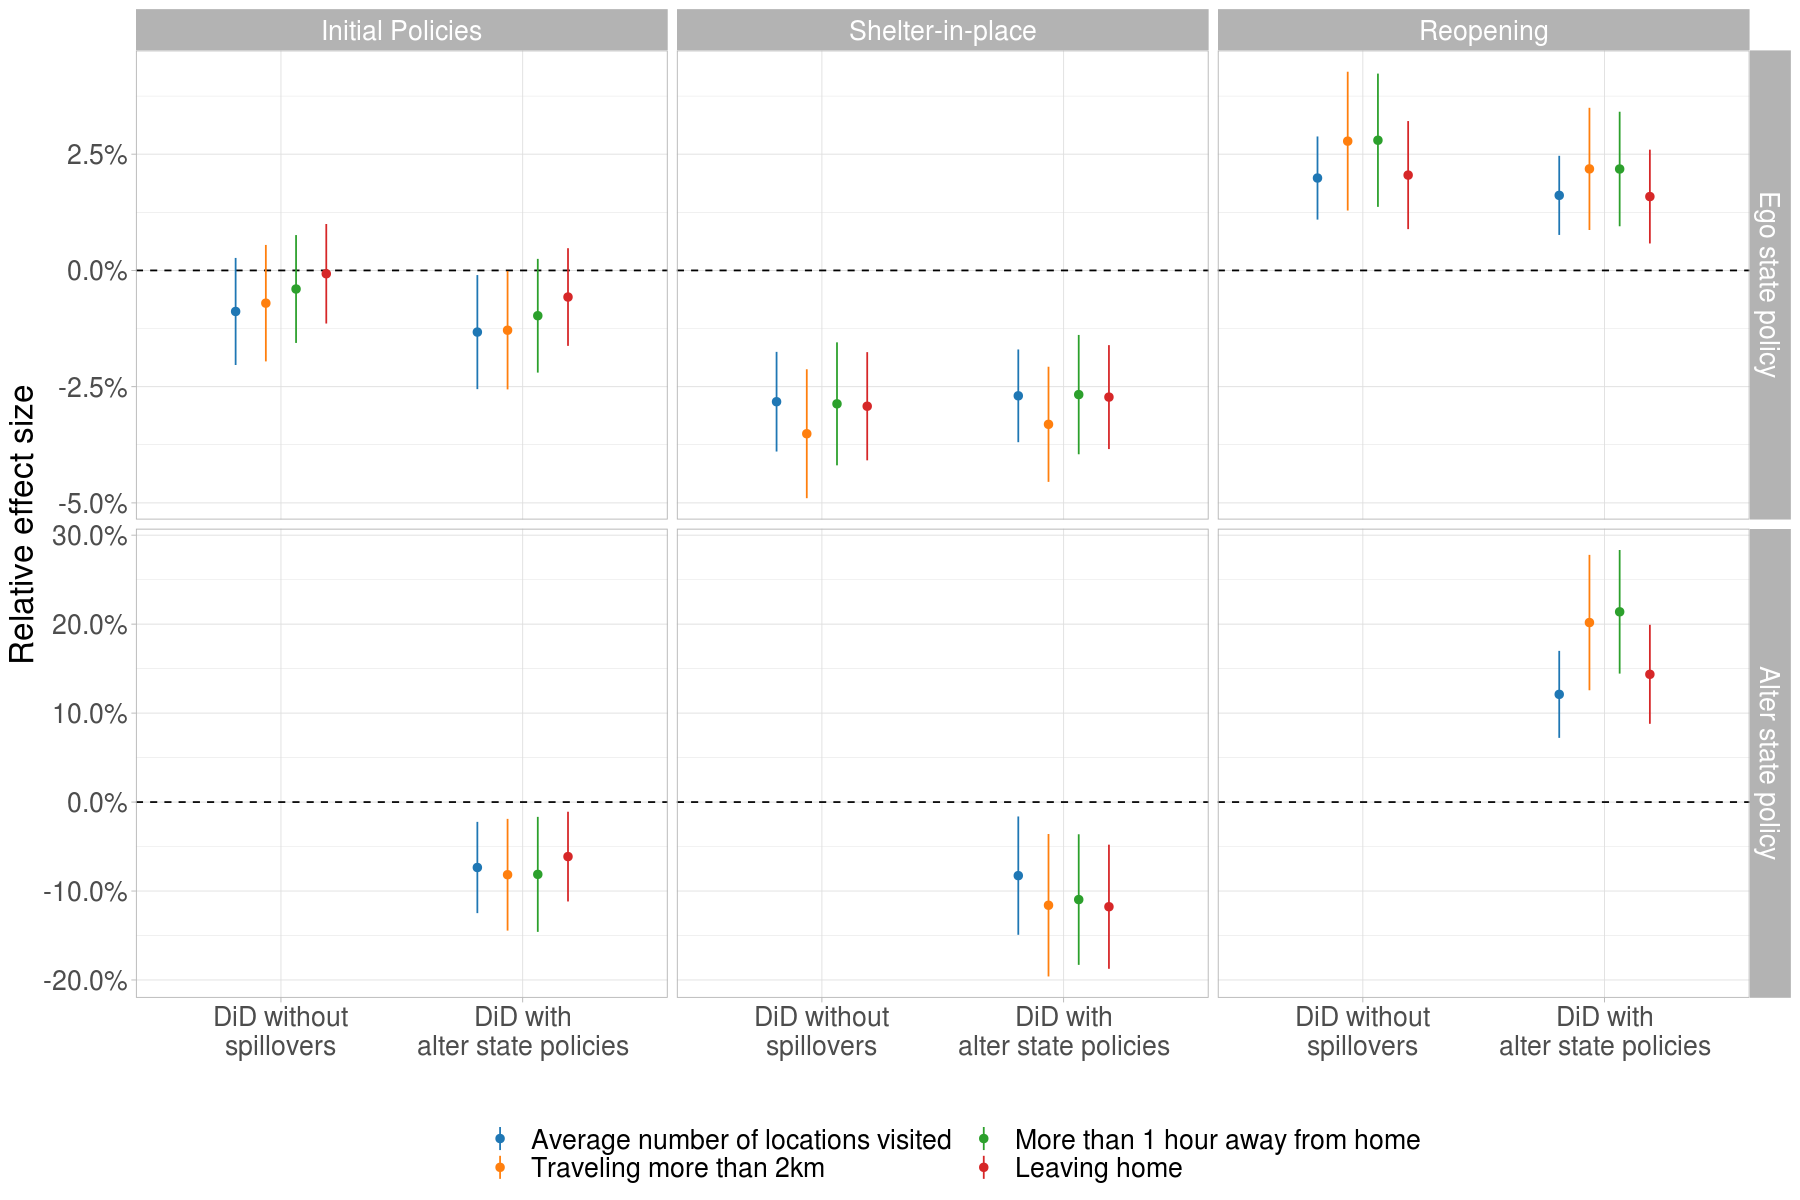

In [10]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening",
        'a'     = 'Ego state policy',
        'b'     = 'Alter state policy')

coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(!str_detect(var, 'unemp')) %>%
    filter(!str_detect(var, 'new')) %>%
    filter(var != 'Peer Effect') %>%
    filter(!str_detect(model, 'iv')) %>%
    filter(!str_detect(model, 'apnf')) %>%
    mutate(vtype = ifelse(str_detect(var, 'stalter'), 'b', 'a'),
           var   = str_replace(var, 'stalter_', ''),
           model = factor(model, levels = c('base', 'base + iv', 'ap', 'ap + iv')),
           dv = case_when(dv == 'log_mcbgv' ~ 'Average number of locations visited',
                         dv == 'log_pgt2kmt' ~ 'Traveling more than 2km',
                         dv == 'log_pgt1hafh' ~ 'More than 1 hour away from home',
                         TRUE ~ 'Leaving home'),
           dv = factor(dv, levels = c('Average number of locations visited', 
                                      'Traveling more than 2km', 
                                      'More than 1 hour away from home', 
                                      'Leaving home')),
           estimate = exp(estimate) - 1,
           u95ci   = exp(estimate + 1.98 * se) - 1,
           l95ci    = exp(estimate - 1.98 * se) - 1,
           model = ifelse(model == 'base', 'DiD without\nspillovers', 'DiD with\nalter state policies'),
           model = factor(model, levels = c('DiD without\nspillovers',
                                           'DiD with\nalter state policies'))) %>%
    ggplot(aes(x = model, y = estimate, color = dv)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .5), size = 2) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), 
                   position = position_dodge(width = .5), size = .5) +
    facet_grid(vtype~var, scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('Relative effect size') +
    scale_color_d3() +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom',
         legend.title = element_blank()) + 
    scale_y_continuous(labels=percent) + 
    guides(color = guide_legend(nrow = 2))-> p2a

#ggsave('/home/dholtz/p4_new.pdf', p2a, device = 'pdf', width = 6.5, height = 5, scale = 2)
p2a

In [ ]:
coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(!str_detect(var, 'new')) %>%
    filter(model == 'apnf') %>%
    filter(str_detect(var, 'stalter')) %>%
    mutate(nf  = ifelse(str_detect(var, 'Near'), 'Near', 'Far'),
           var = str_replace(var, 'stalterNear_', ''),
           var = str_replace(var, 'stalterFar_', '')) %>%
    ggplot(aes(x = var, y = estimate, color = nf)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(0.25)) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), position = position_dodge(0.25)) + 
    facet_grid(dv ~ ., scales = 'free') + 
    theme_light()

In [ ]:
get_models <- function(dv, vars, ivmod = F, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | ')

    if(ivmod == T) {
        alter_weather <- str_c(cns[str_detect(cns, '^stalter_[pt][rm][ca][px][01][0-9]\\.r$')], collapse = ' + ')
        iv <- ifelse(str_detect(dv, 'log'), str_replace(dv, 'log', 'log_stalter'), str_c('stalter_', dv))
        ivf <- str_c('(', iv, ' ~ ', alter_weather, ') | cluster')
        rhs <- str_c(rhs, ivf)
    } else {
        rhs <- str_c(rhs, '0 | cluster')
    }
    form <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df, weights = df$n, ...)
    
    return(model)
}

In [ ]:
foreach(dv = ldvs) %dopar% get_models(dv, f1, F) -> models_base

In [ ]:
stargazer(models_base)

In [ ]:
foreach(dv = ldvs) %dopar% get_models(dv, f2, F) -> models_ap

In [ ]:
stargazer(models_ap)

In [ ]:
foreach(dv = ldvs) %dopar% get_models(dv, f2, T) -> models_apiv

In [ ]:
stargazer(models_apiv)

In [ ]:
condfstat(models_apiv[[1]])
condfstat(models_apiv[[2]])
condfstat(models_apiv[[3]])
condfstat(models_apiv[[4]])

In [ ]:
foreach(dv = ldvs) %dopar% get_models(dv, f2, T, kclass = 'liml') -> models_apiv_liml

In [ ]:
stargazer(models_apiv_liml)

In [ ]:
coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(model == 'ap + iv') -> apiv
    

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening",
        'a'     = 'ego state policy',
        'b'     = 'alter state policy')

coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(var != 'Peer Effect') %>%
    filter(model != 'base + iv') %>%
    mutate(vtype = ifelse(str_detect(var, 'stalter'), 'b', 'a'),
           var   = str_replace(var, 'stalter_', ''),
           model = factor(model, levels = c('base', 'base + iv', 'ap', 'ap + iv')),
           dv = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd'))) %>%
    ggplot(aes(x = model, y = estimate, color = dv)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .5), size = 2) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), 
                   position = position_dodge(width = .5), size = .5) +
    facet_grid(vtype~var, scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('') +
    ggtitle('A') + 
    scale_color_d3() +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'None',
          plot.margin = margin(0, 10, 0, 20)) -> p2a

p2a

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
apiv %>%
    filter(var == 'Peer Effect') %>%
    select(dv, pfxCoef = estimate, pfxSe = se) %>%
    left_join(apiv %>%
              filter(!str_detect(var, 'stalter'),
                     var != 'Peer Effect')) %>%
    mutate(estimate = estimate * pfxCoef,
           se       = estimate * pfxSe,
           var      = str_c('pfx_', var)) %>%
    select(model, dv, var, estimate, se, t, `p-val`) %>%
    bind_rows(apiv %>%
              filter(var != 'Peer Effect',
                     !str_detect(var, 'stalter'))) %>%
    mutate(policy = str_sub(var, -5, -1),
           type   = ifelse(str_detect(var, 'pfx'), 'Peer Effect',
                           ifelse(str_detect(var, 'stalter'), 'Alter Policy', 'Ego Policy')),
           dv = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd'))) %>%
    ggplot(aes(x = type, y = estimate, color = dv)) + 
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .5), size = 2) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), 
                   position = position_dodge(width = .5), size = .5) +
    facet_grid(policy~., scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('') +
    ggtitle('B') +
    scale_color_d3() +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'None', 
          plot.margin = margin(0, 10, 0, 20)) -> p2b

p2b
#ggsave('/home/mfzhao/p2b.svg', p2b, device = 'svg', width = 2, height = 5, scale = 2)

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening",
        'a'     = 'ego state policy',
        'b'     = 'alter state policy')

coefs %>%
    mutate(dv  = str_replace(dv, '\\.r', ''),
           var = str_replace(var, '\\.r', ''),
           var = ifelse(str_detect(var, 'fit'), 'Peer Effect', var)) %>%
    filter(var != 'Peer Effect') %>%
    filter(model != 'base + iv') %>%
    mutate(vtype = ifelse(str_detect(var, 'stalter'), 'b', 'a'),
           var   = str_replace(var, 'stalter_', ''),
           model = factor(model, levels = c('base', 'base + iv', 'ap', 'ap + iv')),
           dv = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd'))) %>%
    ggplot(aes(x = model, y = estimate, color = dv)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .5), size = 2) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), 
                   position = position_dodge(width = .5), size = .5) +
    facet_grid(vtype~var, scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('') +
    scale_color_d3() +
    labs(color = "Outcome") +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom') -> leg


get_legend(leg) %>%
    as_ggplot() -> leg

In [ ]:
p2a + theme(plot.title = element_text(hjust = -0.05, vjust = -1)) -> p2a
p2b + theme(plot.title = element_text(hjust = -0.05, vjust = -1)) -> p2b

In [ ]:
p2a

In [ ]:
p2a + theme(plot.title = element_text(size = 30, hjust = -0.075, vjust = -1.5)) -> p2a
p2b + theme(plot.title = element_text(size = 30, hjust = -0.25, vjust = -1.5)) -> p2b
lay <- rbind(c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             c(rep(1,16), rep(2,8)),
             rep(3, 24))
grid.arrange(grobs = list(p2a, p2b, leg), layout_matrix = lay) -> p2

ggsave('/home/mfzhao/p2.pdf', p2, device = 'pdf', width = 6.5, height = 5, scale = 2)

In [ ]:
ggsave('/home/mfzhao/p2.pdf', p2, device = 'pdf', width = 6.5, height = 5, scale = 2)

In [ ]:
ggsave('/home/mfzhao/p2leg.svg', leg, device = 'svg', width = 6.5, height = 5, scale = 2)